<a href="https://colab.research.google.com/github/ndhcuong/colab/blob/master/exp_content_based_RS_detail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CONTENT BASED RECOMMENDER

## 1. Mô tả chung về bài toán Hệ tư vấn - Recommender system

Cho 1 tập người dùng (users) $ U $ và 1 tập các items $ I $. Các user $ u \in U $ tiến hành đánh giá từng item $ i \in I $ theo thang đo $ s \in S $. Tập hợp dữ liệu đánh giá này được gọi là rating matrix hoặc utility matrix. Ma trận được mô tả như sau:

             
|         | $ u_1 $ | $ u_2 $ | ... | $ u_n $ |
|---------|---------|---------|-----|---------|
| $ i_1 $ |    3    |    ?    |-----|    4    |
| $ i_2 $ |    1    |    5    |-----|    ?    |
|   ...   |   ...   |   ...   |-----|  ...    |
| $ i_m $ |    ?    |    4    |-----|    1    |

Dựa trên dữ liệu đánh giá này, bài toán hệ tư vấn đặt ra là hãy dự đoán rating của user $ u_j $ đối với item $ i_k $ mà user đó chưa đánh giá (nhận giá trị ?)


## 2. Content-based recommender system

CB-RS là một nhánh nghiên cứu đặc thù của RS. Phương pháp tiếp cận của CB-RS như sau:

    * Bước 1: Xây dựng profile cho mỗi item. Nghĩa là, các item được mô tả dưới dạng vector trong không gian n-chiều. Ví dụ: nếu item là movie thì được mô tả trong không gian 19 chiều với mỗi chiều là một thể loại phim (vd: Action, Comedy, ...). Giá trị của mỗi chiều có thể là giá trị nhị phân/ số thực / ... tùy vào từng bài toán cụ thể.
    * Bước 2: Dựa trên item profile này cùng với giá trị rating (đóng vai trò class) tương ứng của user $ u_i $ đối với nó để hình thành nên vector đầu vào cho bài toán ML truyền thống. Việc tập hợp các giá trị rating và item profile vào định dạng này hình thành nên tập dữ liệu train & test cho bài toán classification / regression của machine learning.
    * Bước 3: Dựa vào tập dữ liệu train - test ở bước 2, chúng ta xây dựng các mô hình ML như Regression / SVM / Naive Bayes ... để mô tả hành vi của user và dự đoán rating của user.
    * Bước 4: Tiến hành sử dụng mô hình đã xây dựng để dự đoán và đánh giá hiệu năng của mô hình.

### 2.2 Dữ liệu của bài toán CB-RS

Đối với từng user $ u_i $:

|         | $ d_1 $ | $ d_2 $ | ... | $ d_n $ | $ u_i $ rate |
|---------|---------|---------|-----|---------|--------------|
| $ i_1 $ |    0    |    0    |-----|    1    |      3       |
| $ i_2 $ |    1    |    0    |-----|    0    |      5       |
|   ...   |   ...   |   ...   |-----|  ...    |     ...      |
| $ i_m $ |    0    |    0    |-----|    1    |      1       |

Tập dữ liệu rating này sẽ được chia thành train set và test set. (Mỗi item $ i_j $ được mô tả trong không gian n-chiều $ d_1 $ đến $ d_n $)

### 2.3 Phương pháp xây dựng mô hình

Xây dựng hàm $ f(i, \theta): I \rightarrow R $ với I là tập các item và R là giá trị rating tương ứng.

Hàm $ f(i, \theta) $ có thể được xây dựng bằng nhiều phương pháp khác nhau, như:

Hồi quy: $ f(i, \theta) = \theta_1*d_1^i + \theta_2*d_2^i + ... + \theta_n*d_n^i + b $. Quá trình huấn luyện sẽ tìm ra giá trị cụ thể của từng $ \theta_i $.

Naive bayes, SVM, Mạng nơ-ron nhân tạo, .v.v.

## 3. Thực hành xây dựng CB-RS với tập dữ liệu MovieLens 100k
Mô tả dữ liệu:
    * u.data: chứa toàn bộ các đánh giá của 943 user cho 1682 movies. Mỗi user đánh giá ít nhất là 20 bộ phim.
    * ua.base, ua.test, ub.base, ub.test: là các tập train - test ứng với 2 cách chia khác nhau là (a, b)
    * u.user: chứa đựng thông tin về user (id, tuổi, giới tính, nghệ nghiệp, zipcode (vùng miền))
    * u_genre: chứa tên của 19 thể loại phim như unknown, Action, Comedy, ...
    * u_item: thông tin về mỗi bộ phim 

In [0]:
from google.colab import drive


# thư mục chứa dữ liệu
#home_data = '/drive/Colab Notebooks/recommender/data/movielens100k'
home_data = '/content/drive'

drive.mount(home_data,force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### 3.1 Đọc dữ liệu

In [0]:
import os
import numpy as np
import pandas as pd


# Đọc thông tin về người dùng
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(home_data + 
                    '/My Drive/Colab Notebooks/recommender/data/movielens100k' 
                    + '/' + 'u.user', sep = '|', names = u_cols)
n_users = users.shape[0]
print('Number of users: ', n_users)

Number of users:  943


In [0]:
#Hiển thị 5 dòng đầu tiên
users.head(5)

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [0]:
# Đọc rating profile
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

rating_base = pd.read_csv(home_data + 
                    '/My Drive/Colab Notebooks/recommender/data/movielens100k' 
                    + '/' + 'ua.base', sep = '\t', names = r_cols)
rating_test = pd.read_csv(home_data + 
                    '/My Drive/Colab Notebooks/recommender/data/movielens100k' 
                    + '/' + 'ua.test', sep = '\t', names = r_cols)
print('Number of training instances: ', rating_base.shape[0])
print('Number of testing instances: ', rating_test.shape[0])

Number of training instances:  90570
Number of testing instances:  9430


In [0]:
#Hiển thị 5 dòng đầu của rating_base
rating_base.head(5)

,user_id,movie_id,rating,unix_timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


Chuyển data frame `rating_base` và `rating_test` thành kiểu ma trận của numpy để dễ dàng đưa vào huấn luyện trong các mô hình của `sklearn`.

In [0]:
rate_train = rating_base.as_matrix()
rate_test = rating_test.as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [0]:
#Hiển thị 5 dòng đầu của ma trận rate_test
rate_test[:5,:]

array([[        1,        20,         4, 887431883],
       [        1,        33,         4, 878542699],
       [        1,        61,         4, 878542420],
       [        1,       117,         3, 874965739],
       [        1,       155,         2, 878542201]])

Đọc dữ liệu mô tả item (item profile)

In [0]:
# Doc items file:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 
          'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

items = pd.read_csv(home_data + 
                    '/My Drive/Colab Notebooks/recommender/data/movielens100k' 
                    + '/' + 'u.item', 
                    sep='|', names=i_cols, encoding='latin-1')

n_items = items.shape[0]
print('Number of items:', n_items)

Number of items: 1682


In [0]:
#Hiển thị 3 dòng đầu tiên
items.head(3)

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Do item profile được sử dụng để làm dữ liệu mô tả item trong vector không gian n-chiều, nên cần chuyển dữ liệu về dạng ma trận của numpy để tiện xử lý khi huấn luyện mô hình. Đồng thời chúng ta chỉ cần lấy 19 trường sau cùng của dataframe `items` mà thôi.

In [0]:
# Chi lay cac gia tri nhij phan o 19 cot cuoi moi hang
I0 = items.as_matrix() #chuyển thành ma trận
I_initial_extraction = I0[:, -19:] #lấy ra riêng 19 cột cuối cùng của ma trận

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


### 3.2 Feature engineering

Đến đây chúng ta đã lấy đươc các tập dữ liệu về user $ U $ (`users`), về items $ I $ (`I_inital_extraction`) và về rating `rate_train`, `rate_test`. Do dữ liệu về item có giá trị nhị phân nên ta áp dụng công thức tf-idf để chuyển đổi giá trị của các vector (feature engineering). 

Để thuận tiện với cách mô tả toán thông thường ta đặt tên cho tập dữ liệu sau khi thực hiện feature engineering là `X` tuy nhiên ta vẫn ngầm hiểu rằng X chính là tập dữ liệu mô tả các items.

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(smooth_idf=True, norm ='l2')
X = transformer.fit_transform(I_initial_extraction.tolist()).toarray()

In [0]:
#Hiển thị 3 dòng đầu tiên của X
X[:3, :]

array([[0.        , 0.        , 0.        , 0.74066017, 0.57387209,
        0.34941857, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.53676706, 0.65097024, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.53676706, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        ]])

## 4. Xây dựng mô hình hồi quy cho một user 

Để xây dựng mô hình hồi quy mô hình hóa hành vi của một user, cần:
    * Lấy ra dữ liệu về id của các bộ phim mà user đó đã đánh giá và trọng số đánh giá tương ứng (score)
    * Lấy ra mô tả về các item mà user đó đã đánh giá
    * Xây dựng và huấn luyện mô hình dựa trên các dữ liệu thu được.
    * Đánh giá mô hình với tập dữ liệu test.

### 4.1 Lấy id và rating score của các item 

In [0]:
#Xây dựng hàm lấy item id và score của user k trong tập dữ liệu rating (có thể là train hoặc test)
def get_itemID_score_of_user(rate_matrix, userID):
    #Lấy cột đầu tiên của rate_matrix là cột chứa thông tin userID
    all_user_ids = rate_matrix[:,0]
    #Lọc ra những index có id = userID - lọc ra index những hàng do userID có rate
    # và chuyển kết quả tìm kiếm thành list (sử dụng cú pháp [0]) (do mặc định là mảng 2 chiều)     
    indices = np.where(all_user_ids == userID)[0]
    #Lấy về các itemIDs ở cột thứ 2 của rate_matrix; và trừ cho 1 do stt trong python bắt đầu từ 0
    itemIDs = rate_matrix[indices, 1] - 1
    #Lấy về các rating scores tương ứng ở cột thứ 3 và chuyển thành list
    scores = rate_matrix[indices, 2]
    return (itemIDs, scores)

### 4.2 Huấn luyện mô hình hồi quy

In [0]:
# Lấy dữ liệu itemIDs và scores của user có id = 100
itemIDs, scores = get_itemID_score_of_user(rate_train, 100)
#Xây dựng tập dữ liệu train
X_train = X[itemIDs,:]
y_train = scores

In [0]:
#Các thư viện cần thiết
from sklearn.linear_model import Ridge

#Khởi tạo model
model = Ridge(alpha=0.01, fit_intercept  = True)
#huấn luyện mô hình
model.fit(X_train, y_train)
#Các thông số tìm được sau quá trình học
print('Hệ số : ', model.coef_)
print('Bias: ', model.intercept_)

Hệ số :  [ 0.          1.06478244 -0.69131749  0.          0.13401853  1.27710147
  1.56824185  0.          1.4301213   0.19615854  1.60351936  0.23210467
  1.16683174  1.10712902  1.37676259  1.44483465  1.61476508  1.40803558
  0.        ]
Bias:  1.3579319469184703


### 4.3 Đánh giá mô hình

In [0]:
#Lấy dữ liệu test
itemIDs, y_test = get_itemID_score_of_user(rate_test, 100)
X_test = X[itemIDs, :]
model.score(X_test, y_test)

0.12051951522850424

In [0]:
from sklearn.model_selection import cross_val_score

#Đánh giá theo chỉ số r2
cross_val_score(model, X_test, y_test, cv = 3, scoring='r2')

array([-0.68726621,  0.48956706, -0.23690275])

In [0]:
#Đánh giá theo chỉ số MAE
cross_val_score(model, X_test, y_test, cv = 3, scoring='neg_median_absolute_error')

array([-1.06308401, -0.99073784, -0.50521271])

In [0]:
#Đánh giá theo chỉ số MSE
cross_val_score(model, X_test, y_test, cv = 3, scoring='neg_mean_squared_error')

array([-1.15999552, -0.79400679, -1.09946911])

In [0]:
#Kết quả dự đoán so với kết quả thực tế
print('Test set rated movie ids: ', itemIDs)
print('Actual rating scores: ', y_test)
print('Predicted scores: ', model.predict(X_test))

Test set rated movie ids:  [265 267 287 301 320 339 343 353 354 749]
Actual rating scores:  [2 3 2 4 1 3 4 2 4 4]
Predicted scores:  [1.50195071 3.28561988 2.50811905 4.22630776 2.63503341 2.78805324
 2.78805324 3.22626107 2.66294969 2.78805324]


In [0]:
#Đánh giá theo chỉ số Negative MSE
eval_scores = cross_val_score(model, X_test, y_test, cv = 3, scoring='neg_mean_squared_error')
print('Negative MSE = ', eval_scores.mean())

Negative MSE =  -1.017823808327644


### 4.4 Vẽ đường validation curve
Xét trên tập dữ liệu train (chưa ổn)


In [0]:
# Lấy dữ liệu itemIDs và scores của user có id = 100
itemIDs, y_train = get_itemID_score_of_user(rate_train, 100)
#Xây dựng tập dữ liệu train
X_train = X[itemIDs,:]

In [0]:
#Xáo trộn thứ tự dữ liệu
indices = np.arange(y_train.shape[0])
np.random.shuffle(indices)
X_train, y_train = X_train[indices, :], y_train[indices]

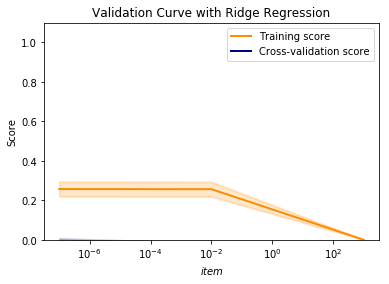

In [0]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

%matplotlib inline
param_range = np.logspace(-7, 3, 3)
train_scores, test_scores = validation_curve(Ridge(), X_train, y_train, "alpha",
                                                param_range,
                                                cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Ridge Regression")
plt.xlabel("$item$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

## 5. Xây dựng mô hình hồi quy dự đoán cho tất cả các user

In [0]:
print(n_users)

943


In [0]:
#bien luu gia tri nmse chung cho tat ca cac model
nmse = []

for userID in range(n_users):
    # Lấy dữ liệu itemIDs và scores của user 
    itemIDs, y_train = get_itemID_score_of_user(rate_train, userID + 1)
    #Xây dựng tập dữ liệu train
    X_train = X[itemIDs,:]
    #Khởi tạo model
    model = Ridge(alpha=0.01, fit_intercept  = True)
    #huấn luyện mô hình
    model.fit(X_train, y_train)
    #Lấy dữ liệu test
    itemIDs, y_test = get_itemID_score_of_user(rate_test, 100)
    X_test = X[itemIDs, :]
    #Đánh giá theo chỉ số Negative MSE
    eval_scores = cross_val_score(model, X_test, y_test, cv = 3, scoring='neg_mean_squared_error')
    nmse.append(eval_scores.mean())

print('NMSE for testing: ', np.mean(nmse))

NMSE for testing:  -1.0178238083276445
